In [1]:
#8qubitのHardware Efficent(HWE)回路
import pennylane as qml
import numpy as np
from math import pi
import matplotlib.pyplot as plt

default_wires = 8

dev = qml.device('default.qubit', wires=default_wires)

#HWE
@qml.qnode(dev)
def circuit(weights_gen, params_rand):
    layers = weights_gen.shape[0]

    #ランダムな積状態を生成
    for i in range(default_wires):
        qml.RZ(params_rand[i][1], wires=i)
        qml.RY(params_rand[i][0], wires=i)

    #HWE
    for d in range(layers):
        for i in range(default_wires):
            qml.U3(weights_gen[d][i][0],weights_gen[d][i][1],weights_gen[d][i][2], wires=i)

        for i in range(int(default_wires/2)):
            qml.CZ(wires=[2*i,2*i+1])

        for i in range(default_wires):
            qml.U3(weights_gen[d][i][0],weights_gen[d][i][1],weights_gen[d][i][2], wires=i)

        for i in range(int((default_wires-1)/2)):
            qml.CZ(wires=[2*i+1,2*i+2])


    return qml.state()

#Concentratable Entanglementの計算  
def concentratable_entanglement(state):
    power_set = []
    for i in range(1,2**default_wires): 
        subset = [j for j in range(default_wires) if (i & (1 << j))]
        power_set.append(subset)

    purity_sum  = 0
    #部分系の密度行列の純粋度の和
    for subset in power_set:
        rho = qml.math.reduce_statevector(state,subset)
        trace = np.trace(rho @ rho).real
        purity_sum += trace
    #空集合の場合
    purity_sum += 1

    CE = 1 - ( 1 / (2**default_wires))  * purity_sum
    return  CE

0: ──RZ(3.32)──RY(4.40)──U3(-0.67,0.56,0.44)──╭●──U3(-0.67,0.56,0.44)───U3(-0.60,0.35,0.47)─
1: ──RZ(4.91)──RY(3.99)──U3(-0.71,0.31,0.37)──╰Z──U3(-0.71,0.31,0.37)──╭●───────────────────
2: ──RZ(3.81)──RY(3.11)──U3(0.67,-0.38,-0.54)─╭●──U3(0.67,-0.38,-0.54)─╰Z───────────────────
3: ──RZ(2.43)──RY(2.76)──U3(0.43,-0.11,0.07)──╰Z──U3(0.43,-0.11,0.07)──╭●───────────────────
4: ──RZ(2.27)──RY(5.89)──U3(1.08,-0.24,0.73)──╭●──U3(1.08,-0.24,0.73)──╰Z───────────────────
5: ──RZ(2.25)──RY(0.35)──U3(-0.44,0.72,1.14)──╰Z──U3(-0.44,0.72,1.14)──╭●───────────────────
6: ──RZ(6.24)──RY(3.70)──U3(0.28,-0.97,-0.68)─╭●──U3(0.28,-0.97,-0.68)─╰Z───────────────────
7: ──RZ(5.52)──RY(4.76)──U3(0.01,0.26,0.66)───╰Z──U3(0.01,0.26,0.66)────U3(0.12,-0.35,-0.25)

─────────────────────────╭●──U3(-0.60,0.35,0.47)────U3(-0.65,0.12,0.06)─────────────────────────╭●
───U3(0.03,0.10,0.26)────╰Z──U3(0.03,0.10,0.26)────╭●─────────────────────U3(-0.67,-0.38,-0.33)─╰Z
───U3(0.25,-0.32,-0.27)──╭●──U3(0.25,-0.32,-0.27)──╰Z────

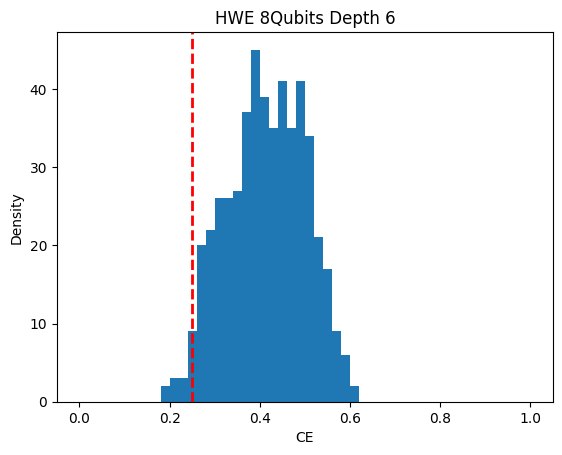

In [2]:
#CEの分布の確認用のコード

#CE=0.25(0.10)のパラメータを利用すると、CEの平均＝0.4(0.25)程度になる
#データセットの作成には、実際の観測したCEの値を利用する

#HWE回路のパラメータの読み込み（Depth=6,CE=0.25を想定）
weights_gen = np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/8_Qubits/Depth_6/hwe_8q_cb_25_6_weights.npy')
#(Depth=6,CE=0.10)
#weights_gen = np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/8_Qubits/Depth_6/hwe_8q_cb_10_6_weights.npy')

x=[]

#回路の描画
print(qml.draw(circuit)(weights_gen, np.random.uniform(0, 2 * np.pi, (default_wires, 2))) )       

for i in range(500):
    params_rand = np.random.uniform(0, 2 * np.pi, (default_wires, 2))
    state = circuit(weights_gen, params_rand)
    x.append(concentratable_entanglement(state))
    
    print(i, x[i])


plt.hist(x,bins=50,range=(0, 1.0))
plt.title("HWE 8Qubits Depth 6")
plt.xlabel('CE')
plt.ylabel('Density')
plt.axvline(0.25, color='red', linestyle='dashed', linewidth=2, label=f'Theoretical mean: {0.05}')

print("平均", np.mean(x))
plt.show()


In [3]:
#データセットの出力
#ここでは, CEが0.20,0.40のデータセットを作成する
#入力= ランダムな積状態を作りだすためのパラメータ, 出力= HWEを作用させてできる状態のCEの理論値に対応する値 -1 or 1
import csv
import random 

#HWE回路のパラメータの読み込み
weights_025_40 = np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/8_Qubits/Depth_6/hwe_8q_cb_25_6_weights.npy')
weights_010_20 = np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/8_Qubits/Depth_6/hwe_8q_cb_10_6_weights.npy')

#目標のCEの値
optimal_ce_40 = 0.40
optimal_ce_20 = 0.20

#データセットの個数指定
trainDataQuantities = 240
testDataQuantities = 60

#train だったらflag = true , test だったら flag = false

flag = True 

if flag:
    print("create train dataset")
    array = [-1] * int(trainDataQuantities /2 ) + [1] * int(trainDataQuantities /2)
    file_name = 'train_HWE_8q_6_20_40_no2.csv'
    count_limit = trainDataQuantities
else: 
    print("create test dataset")
    array = [-1] * int(testDataQuantities /2 ) + [1] * int(testDataQuantities /2)
    file_name = 'test_HWE_8q_6_20_40_no2.csv'
    count_limit = testDataQuantities

random.shuffle(array)

count= 0

with open(file_name, mode = 'a', newline = '', encoding = 'utf-8') as file:

    writer = csv.writer(file)

    while count < count_limit:
        if array[count] == -1:
            optimal_ce = optimal_ce_20
            weights = weights_010_20
        else:
            optimal_ce = optimal_ce_40
            weights = weights_025_40

        #ランダムな積状態を作るためのパラメータ
        params_rand = np.random.uniform(0, 2 * np.pi, (default_wires, 2))

        state = circuit(weights, params_rand)
        CE = concentratable_entanglement(state)

        #CEが理論値の範囲内ならデータセットに追加
        if(abs(CE - optimal_ce) < 0.10):
            tmp_csv = params_rand.flatten()
            if array[count] == -1:
                tmp_csv = np.append(tmp_csv, -1)
                tmp_csv = np.append(tmp_csv, -1)
            else:
                tmp_csv = np.append(tmp_csv, 1)
                tmp_csv = np.append(tmp_csv, 1)
            writer.writerow(tmp_csv)

            count += 1
            print(count, CE)
        else:

            continue

create train dataset
1 0.11538063558675582
2 0.10173972954168509
3 0.16392825525501387
4 0.13653254336627352
5 0.44728679628676005
6 0.4019596748591421
7 0.4533376633701329
8 0.4995752430195799
9 0.27239477512231214
10 0.17110052234429662
11 0.3554780657984178
12 0.3423428495064521
13 0.320276170201236
14 0.43291659180386155
15 0.2109308187277924
16 0.47633339604414515
17 0.435372765004329
18 0.35720458777252195
19 0.35381218591018904
20 0.2856252612689967
21 0.4446970777447923
22 0.2891065696081151
23 0.22752925061904883
24 0.3393580336729535
25 0.1546770216649016
26 0.18218184030940598
27 0.10253148992979022
28 0.1902254502186148
29 0.3832358211974408
30 0.46593370310873283
31 0.33643213943511896
32 0.4913501514609119
33 0.18655366247024407
34 0.41327871903095004
35 0.4902311509336599
36 0.18410140875494585
37 0.12513044008971674
38 0.39118397284947004
39 0.46863343192104434
40 0.43415315582845415
41 0.4629900506271011
42 0.2784258643699685
43 0.49161110060248825
44 0.437467810699833

KeyboardInterrupt: 